In [ ]:
#Thêm các thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

#khai báo hàm os liệt kê tất cả các tệp trong thư mục đầu vào
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#định nghĩa hai biến traindir và validdir chứa đường dẫn đến các thư mục Training và Validation tương ứng
traindir = "/content/drive/MyDrive/Gemaden/Dataset"
validdir = "/content/drive/MyDrive/Gemaden/Dataset"
#liệt kê tất cả các tệp trong traindir
os.listdir(traindir)

['female', 'male']

In [ ]:
#Khai báo hàm show_image dùng liệt kê ảnh
def show_image(dir):
#định nghĩa kích thước của hình ảnh đầu ra
    plt.figure(figsize=(12,7))
#vòng lặp for được sử dụng để lặp qua 10 tệp hình ảnh được chọn ngẫu nhiên bằng random.choice(os.listdir(dir)).
#Hình ảnh được tải bằng load_img(os.path.join(dir,img)).
    for i in range(10):
#Trong mỗi vòng lặp, subplot được tạo ra để chứa hình ảnh tương ứng
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
 #plt.subplots_adjust được sử dụng để tạo khoảng cách dọc giữa các subplot.
        plt.subplots_adjust(hspace=0.2)
#biến x được định nghĩa là tên của thư mục được chia cắt từ đường dẫn đầu vào dir và được sử dụng để đặt tiêu đề chính của tất cả các subplot sẽ được hiển thị.
        x = dir.split("/")[-1]
        if x == "male":
            plt.suptitle("Male Images",fontsize=16)
        else:
            plt.suptitle("Female Images",fontsize=15)
#plt.imshow(img) được sử dụng để hiển thị hình ảnh trên subplot tương ứng.
        plt.imshow(img)
#được sử dụng để điều chỉnh vị trí của các subplot để chúng trông đẹp hơn và đồng đều hơn.
    plt.tight_layout()

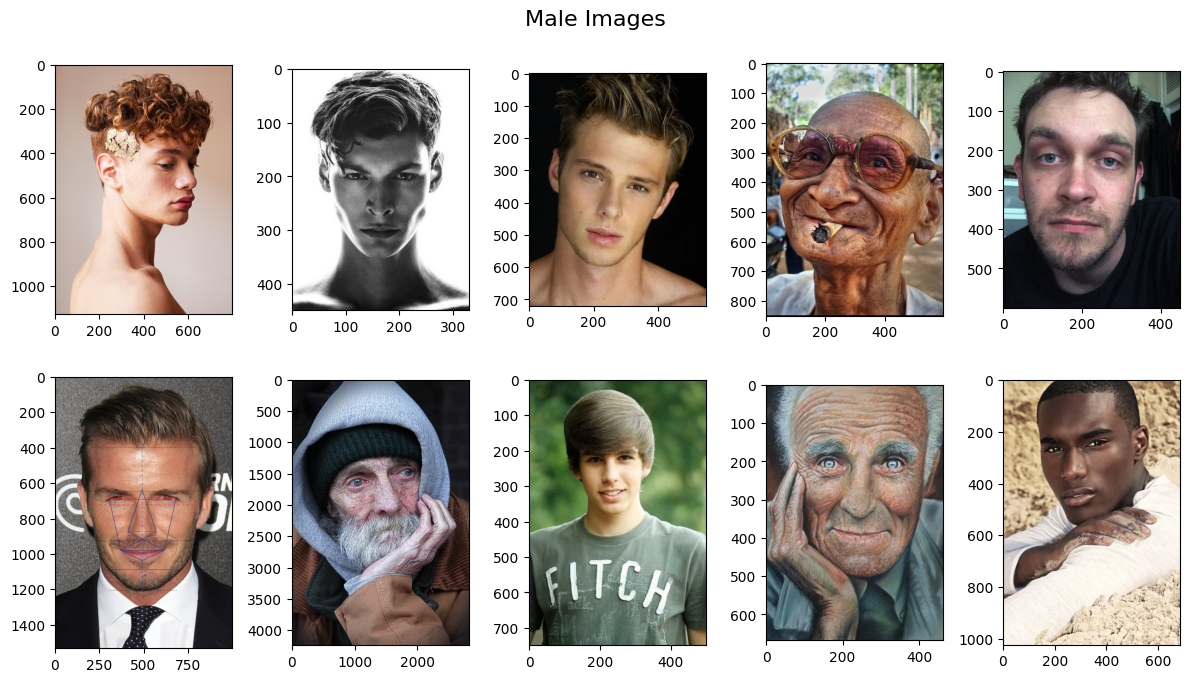

In [ ]:
show_image("/content/drive/MyDrive/Gemaden/Dataset/male")

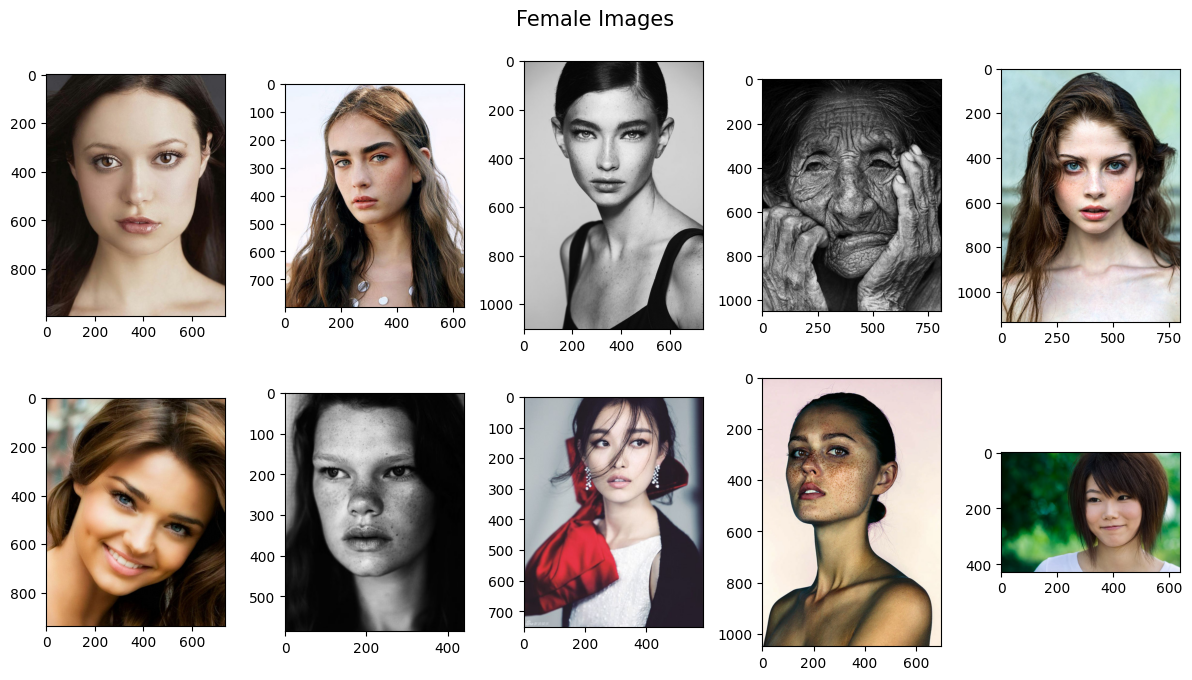

In [ ]:
show_image("/content/drive/MyDrive/Gemaden/Dataset/female")

In [ ]:
height = 150
width = 150
train_datagen =  ImageDataGenerator(rescale = 1/255.0,rotation_range=45,height_shift_range=0.2,shear_range=0.2,
                              zoom_range=0.2,validation_split=0.2,horizontal_flip=True)

train_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="training")

val_datagen = ImageDataGenerator(rescale = 1/255.0)

val_data = train_datagen.flow_from_directory(directory = traindir,target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="validation")

Found 4367 images belonging to 2 classes.
Found 1091 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(height,width,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
model = Sequential()
model.add(mobilenet)
model.add(Dense(128,activation="relu"))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2,activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 5, 5, 128)         163968    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6402      
                                                                 
Total params: 2,428,354
Trainable params: 170,370
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint("Gender.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_acc',patience=5,verbose=1)

In [ ]:
batch_size = 32
history = model.fit_generator(train_data,steps_per_epoch = len(train_data)// batch_size,epochs=15,
                              validation_data = val_data,validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],verbose=1)

<ipython-input-18-146ef6cbe80c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,steps_per_epoch = len(train_data)// batch_size,epochs=15,
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.6719 
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to Gender.h5


4/4 [==============================] - 95s 25s/step - loss: 0.9977 - accuracy: 0.6719 - val_loss: 0.7328 - val_accuracy: 0.7500
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.7734 
Epoch 2: val_accuracy did not improve from 0.75000


4/4 [==============================] - 83s 21s/step - loss: 0.8391 - accuracy: 0.7734 - val_loss: 1.1305 - val_accuracy: 0.7188
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8359 
Epoch 3: val_accuracy did not improve from 0.75000


4/4 [==============================] - 71s 19s/step - loss: 0.3910 - accuracy: 0.8359 - val_loss: 0.6142 - val_accuracy: 0.7188
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.8203 
Epoch 4: val_accuracy improved from 0.75000 to 0.81250, saving model to Gender.h5


4/4 [==============================] - 69s 19s/step - loss: 0.5585 - accuracy: 0.8203 - val_loss: 0.4667 - val_accuracy: 0.8125
Epoch 5/15
4/4 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.8281 
Epoch 5: val_accuracy did not improve from 0.81250


4/4 [==============================] - 61s 17s/step - loss: 0.4736 - accuracy: 0.8281 - val_loss: 0.6567 - val_accuracy: 0.7188
Epoch 6/15
4/4 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8047 
Epoch 6: val_accuracy did not improve from 0.81250


4/4 [==============================] - 75s 21s/step - loss: 0.3452 - accuracy: 0.8047 - val_loss: 0.8300 - val_accuracy: 0.6875
Epoch 7/15
4/4 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8359 
Epoch 7: val_accuracy improved from 0.81250 to 0.84375, saving model to Gender.h5


4/4 [==============================] - 66s 18s/step - loss: 0.3623 - accuracy: 0.8359 - val_loss: 0.2919 - val_accuracy: 0.8438
Epoch 8/15
4/4 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8516
Epoch 8: val_accuracy did not improve from 0.84375


4/4 [==============================] - 55s 15s/step - loss: 0.3360 - accuracy: 0.8516 - val_loss: 0.4733 - val_accuracy: 0.8438
Epoch 9/15
4/4 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9141
Epoch 9: val_accuracy did not improve from 0.84375


4/4 [==============================] - 56s 16s/step - loss: 0.2675 - accuracy: 0.9141 - val_loss: 0.4623 - val_accuracy: 0.8125
Epoch 10/15
4/4 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8516
Epoch 10: val_accuracy improved from 0.84375 to 0.87500, saving model to Gender.h5


4/4 [==============================] - 52s 14s/step - loss: 0.3419 - accuracy: 0.8516 - val_loss: 0.2585 - val_accuracy: 0.8750
Epoch 11/15
4/4 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8281
Epoch 11: val_accuracy did not improve from 0.87500


4/4 [==============================] - 51s 14s/step - loss: 0.4160 - accuracy: 0.8281 - val_loss: 0.2589 - val_accuracy: 0.8438
Epoch 12/15
4/4 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8516
Epoch 12: val_accuracy improved from 0.87500 to 0.93750, saving model to Gender.h5


4/4 [==============================] - 47s 12s/step - loss: 0.3639 - accuracy: 0.8516 - val_loss: 0.2117 - val_accuracy: 0.9375
Epoch 13/15
4/4 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8203
Epoch 13: val_accuracy did not improve from 0.93750


4/4 [==============================] - 40s 11s/step - loss: 0.3979 - accuracy: 0.8203 - val_loss: 0.2146 - val_accuracy: 0.9062
Epoch 14/15
4/4 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8438
Epoch 14: val_accuracy did not improve from 0.93750


4/4 [==============================] - 44s 12s/step - loss: 0.3461 - accuracy: 0.8438 - val_loss: 0.3179 - val_accuracy: 0.8750
Epoch 15/15
4/4 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8594
Epoch 15: val_accuracy improved from 0.93750 to 0.96875, saving model to Gender.h5


4/4 [==============================] - 42s 11s/step - loss: 0.3603 - accuracy: 0.8594 - val_loss: 0.1500 - val_accuracy: 0.9688


In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 190s 6s/step - loss: 0.3364 - accuracy: 0.8552


[0.33642780780792236, 0.855178713798523]

In [ ]:
def checking(img):
    label = {0:"female",1:"male"}
    image =cv2.imread(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier("/content/drive/MyDrive/Gemaden/xml/haarcascade_frontalface_default.xml")
    faces = cascade.detectMultiScale(gray,1.1,7)#1.1

    for x,y,w,h in faces:
        face = image[y:y+h,x:x+w]
        face = cv2.resize(face,(150,150))
        img_scaled = face/255.0
        reshape = np.reshape(img_scaled,(1,150,150,3))
        img = np.vstack([reshape])
        result = np.argmax(model.predict(img), axis=-1)

        if result == 0:
            cv2.rectangle(image,(x-10,y),(x+w,y+h),(0,255,0),4)
            cv2.rectangle(image,(x-10,y-50),(x+w,y),(255,0,0),-1)
            cv2.putText(image,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)


            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            plt.imshow(image)

1/1 [==============================] - 0s 46ms/step


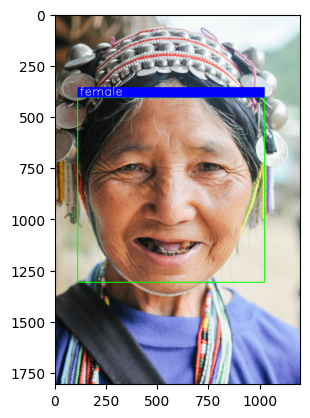

In [ ]:
checking("/content/drive/MyDrive/Gemaden/Dataset/female/0 (1021).jpg")

1/1 [==============================] - 0s 46ms/step


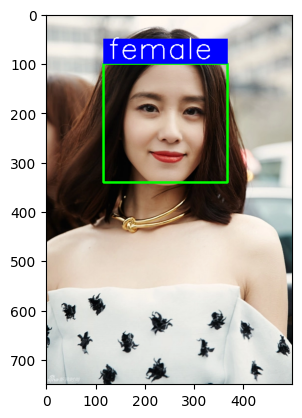

In [ ]:
checking("/content/ngat-ngay-voi-danh-sach-top-10-nu-than-chau-a.webp")

1/1 [==============================] - 0s 43ms/step


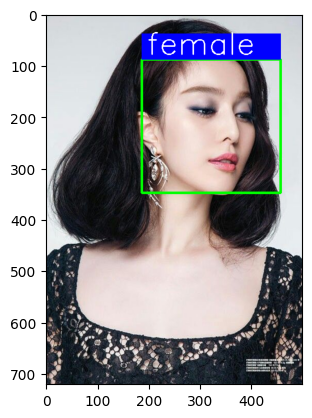

In [ ]:
checking("/content/7fe13862cb5125c8fb45301948da3cf0.jpg")

1/1 [==============================] - 0s 62ms/step


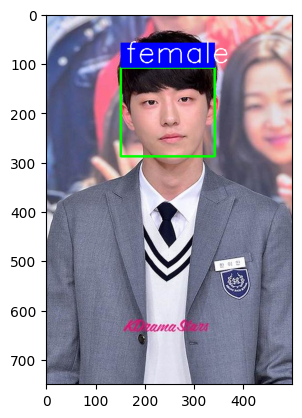

In [ ]:
checking("/content/joo.jfif")

1/1 [==============================] - 0s 81ms/step


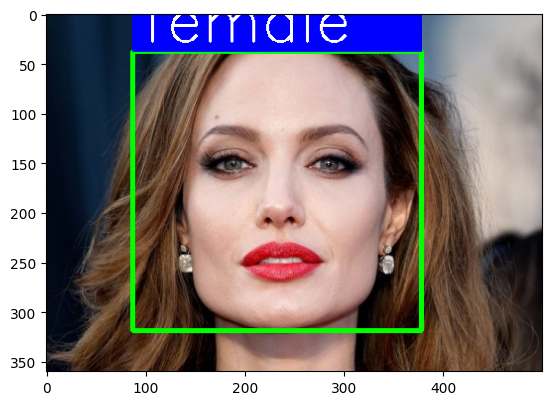

In [ ]:
checking("/content/R (1).jfif")

In [ ]:
checking("/content/unnamed-10-ohay-tv-280.jpg")

1/1 [==============================] - 0s 83ms/step
